In [1]:
import pandas as pd
from pyextremes import EVA
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn import datasets
import math
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from datetime import datetime

from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')


In [2]:
####################### test stationary of dataset##############
def test_stationarity(timeseries, n):
    #Determing rolling statistics
    rolmean = timeseries.rolling( n ).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling( n ).std()
    #rolstd = pd.rolling_std(timeseries, window=12)
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:' )
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)



In [4]:
pth0 = r"../data/gaugestation/Sea-levelDailyData.csv"
pth1 = r"../data/gaugestation/Hourly_RQTGD_Galveston.csv"


In [43]:
series = pd.read_csv( pth1, index_col = 1,
                     parse_dates = True ).squeeze()
series.columns


Index(['sea_level', 'station_name', 'station_country', 'station_country_code',
       'record_id', 'uhslc_id', 'version', 'gloss_id', 'ssc_id',
       'decimation_method', 'reference_code', 'reference_offset'],
      dtype='object')

In [44]:
series = series.iloc[1:]
series['Times'] = series.index.str.slice(start=0, stop=10) + " "+ series.index.str.slice(start=11, stop=19)

series['Times'] = pd.to_datetime(series['Times'], format= "%Y-%m-%d %H:%M:%S")
series['Year']  = series.Times.dt.year.tolist()

filtered_df = series.loc[(series['Times'] >= '2017-01-01')
                     & (series['Times'] < '2020-09-15')] 
series.set_index(['Times'], inplace = True)

In [597]:
#series.columns = ['sea_level', 'time (UTC)', 'station_name', 'station_country', 
#                  'station_country_code', 'record_id', 'uhslc_id', 'version', 
#                  'gloss_id', 'ssc_id', 'decimation_method', 'reference_code', 'reference_offset']


In [10]:
filtered_df.set_index(['Times'], inplace = True)
filtered_df= filtered_df['sea_level']


In [11]:
series.loc[ series['Year'] > 2017 ]


In [12]:
series = series['sea_level']
series.tail()

Times
2019-10-31 19:00:00    1202
2019-10-31 19:59:59    1273
2019-10-31 21:00:00    1350
2019-10-31 22:00:00    1455
2019-10-31 22:59:59    1562
Name: sea_level, dtype: object

In [17]:
series = (
    series
    .sort_index(ascending=True)
    .astype(float)
    .dropna()
    .loc[pd.to_datetime("1904"):]
)

#series = series - (series.index.array - pd.to_datetime("1904")) / pd.to_timedelta("365.2425D") * 2.87e-3

series

Times
1904-01-01 07:00:00     991.999993
1904-01-01 07:59:59     960.999992
1904-01-01 09:00:00     899.999991
1904-01-01 10:00:00     808.999990
1904-01-01 10:59:59     655.999989
                          ...     
2019-10-31 19:00:00    1201.002662
2019-10-31 19:59:59    1272.002661
2019-10-31 21:00:00    1349.002660
2019-10-31 22:00:00    1454.002659
2019-10-31 22:59:59    1561.002658
Name: sea_level, Length: 981715, dtype: float64

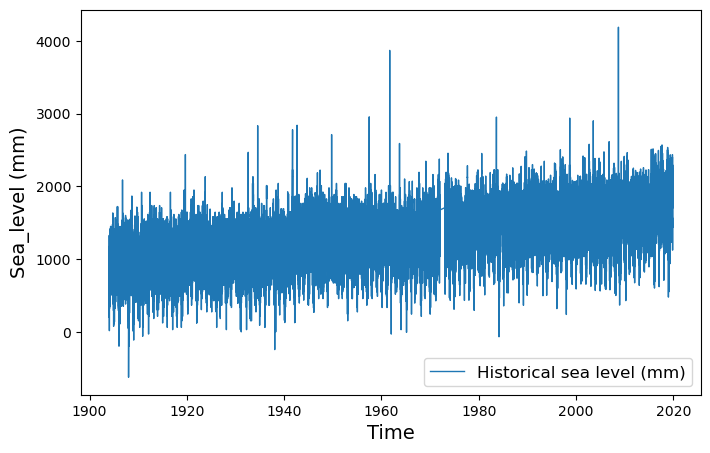

In [18]:
###############################################################################
fig = plt.figure(figsize=(8,5))

plt.plot(series, linewidth= 1 )
plt.legend(["Historical sea level (mm)"], loc ="lower right", fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Sea_level (mm)', fontsize=14)
fig.savefig('/Users/yuhan/Desktop/sealevel_raw.jpg', bbox_inches='tight', dpi=300)

plt.show()
###############################################################################

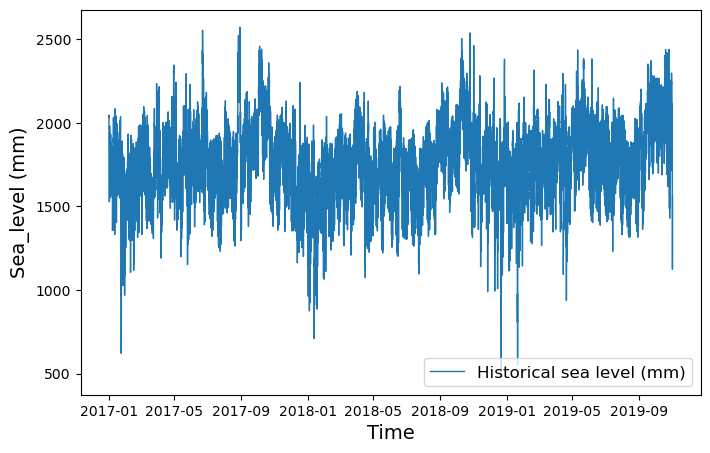

In [19]:
###############################################################################
fig = plt.figure(figsize=(8,5))

plt.plot(filtered_df, linewidth= 1 )
plt.legend(["Historical sea level (mm)"], loc ="lower right", fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Sea_level (mm)', fontsize=14)
fig.savefig('/Users/yuhan/Desktop/sealevel_raw17.jpg', bbox_inches='tight', dpi=300)

plt.show()
###############################################################################

In [20]:
###############################################################################
#series = series - (series.index.array - pd.to_datetime("1992")) / pd.to_timedelta("365.2425D") * 2.87e-3
model_BM = EVA(series)
model_BM.get_extremes(method="BM", block_size="365.2425D")

###############################################################################

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='Times', ylabel='sea_level'>)

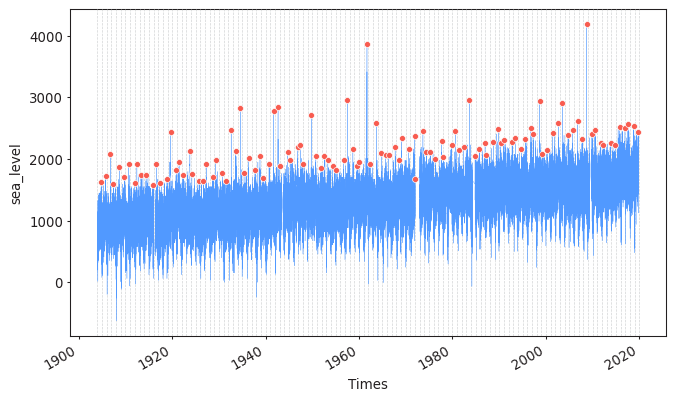

In [71]:
model_BM.plot_extremes()

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='sea_level'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='sea_level', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

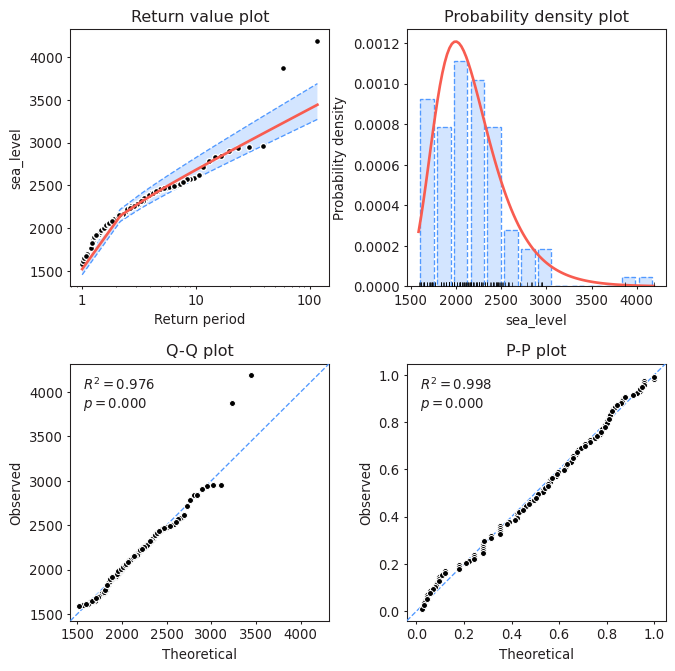

In [72]:
model_BM.fit_model()

summary = model_BM.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000
)
model_BM.plot_diagnostic(alpha=0.95)

In [21]:
###############################################################################
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes


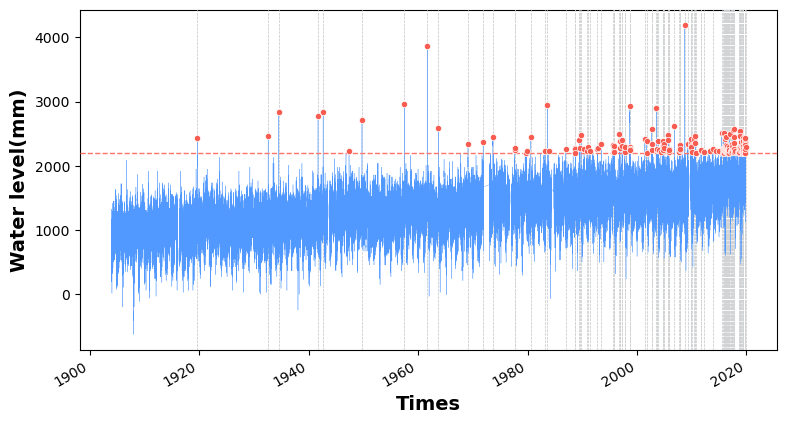

In [22]:
extremes = get_extremes( series, "POT", threshold= 2200, r="12H")

fig, ax = plt.subplots( figsize=( 9, 5) )

outputs = plot_extremes(
    ax = ax,
    ts= series,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    threshold= 2200,
    r="12H" )
ax.set_xlabel('Times',  
               fontweight ='bold', size = 14) 
ax.set_ylabel('Water level(mm)',  
               fontweight ='bold', size = 14) 
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
fig.savefig('Sea_Level_Rise.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

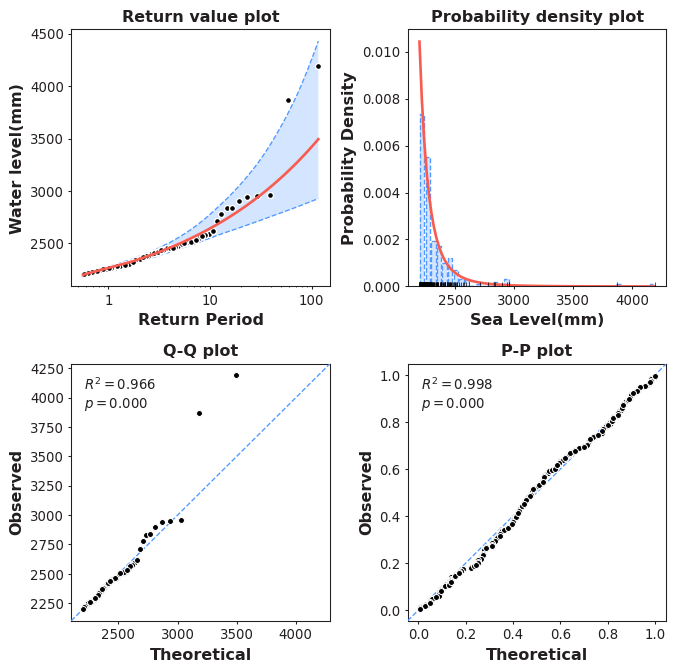

In [75]:

model_POT = EVA(series)
model_POT.get_extremes(method="POT", threshold= 2200, r="12H")

model_POT.fit_model()

#fig, ax = plt.subplots( 4, figsize=( 9, 5) )
fig2, (ax1, ax2, ax3, ax4) = model_POT.plot_diagnostic(alpha=0.95)
ax1.set_xlabel('Return Period',  
               fontweight ='bold', size = 12) 
ax1.set_ylabel('Water level(mm)',  
               fontweight ='bold', size = 12) 
ax1.set_title( 'Return value plot', fontweight ='bold', size = 12 )
ax2.set_xlabel('Sea Level(mm)',  
               fontweight ='bold', size = 12) 
ax2.set_ylabel('Probability Density',  
               fontweight ='bold', size = 12) 
ax2.set_title( 'Probability density plot', fontweight ='bold', size = 12)
ax3.set_xlabel('Theoretical',  
               fontweight ='bold', size = 12) 
ax3.set_ylabel('Observed',  
               fontweight ='bold', size = 12) 
ax3.set_title( 'Q-Q plot', fontweight ='bold', size = 12)
ax4.set_xlabel('Theoretical',  
               fontweight ='bold', size = 12) 
ax4.set_ylabel('Observed',  
               fontweight ='bold', size = 12) 
ax4.set_title( 'P-P plot', fontweight ='bold', size = 12)

extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("ax2_figure.pdf", format="pdf", bbox_inches=extent)


#fig2.savefig('Diagnostics_Sealevel.png', format='png', dpi=600, bbox_inches='tight')
fig2.savefig("Diagnostics_Sealevel.pdf", format="pdf", bbox_inches="tight")


In [76]:

summary = model_POT.get_summary(
    return_period=[10, 25, 50, 100, 200],
    alpha=0.95)
print( summary )


               return value     lower ci     upper ci
return period                                        
10.0            2642.261207  2549.879590  2776.147363
25.0            2887.720413  2685.716929  3174.905190
50.0            3125.486425  2790.986741  3616.044964
100.0           3420.046839  2901.610499  4254.089570
200.0           3784.967952  3018.811252  5174.091900


In [77]:
model_POT.distribution

       pyextremes distribution       
-------------------------------------
name: genpareto                      
free parameters: c, scale            
fixed parameters: floc=2,200.000     
MLE parameters: c=0.309, scale=95.077
-------------------------------------

In [107]:
model0 = EVA(series)
model0.get_extremes(method="POT", threshold= 2200, r="12H")
print(model0.extremes.head())

extreme_values = model0.extremes

Times
1919-09-15 13:00:00    2437.954923
1932-08-14 03:00:00    2468.917862
1934-07-25 10:59:59    2834.912280
1941-09-24 03:00:00    2779.891711
1942-08-30 04:59:59    2840.889038
Name: sea_level, dtype: float64


In [108]:
print( extreme_values.shape )
extreme_values_df  = pd.DataFrame() 
extreme_year       = pd.DatetimeIndex( extreme_values.index ).year
extreme_values_df['exsealevel']     = extreme_values
extreme_values_df['year']           = extreme_year
#extreme_values_df['yearly_avg']     = extreme_values_df.groupby(["year"]).sealevel.transform('count')


(207,)


In [541]:
#extreme_values.resample('10y').count().plot()

In [540]:
#series.tail()

In [23]:
series_year = pd.DatetimeIndex( series.index ).year
series_year

Int64Index([1904, 1904, 1904, 1904, 1904, 1904, 1904, 1904, 1904, 1904,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='Times', length=981715)

In [24]:
series_df = pd.DataFrame() 
series_df['sealevel'] = series
series_df['year'] = series_year
series_df['yearly_avg']    = series_df.groupby(["year"]).sealevel.transform('mean')

In [25]:
series_df.head()


,sealevel,year,yearly_avg
Times,,,
1904-01-01 07:00:00,991.999993,1904,968.051283
1904-01-01 07:59:59,960.999992,1904,968.051283
1904-01-01 09:00:00,899.999991,1904,968.051283
1904-01-01 10:00:00,808.999990,1904,968.051283
1904-01-01 10:59:59,655.999989,1904,968.051283


In [538]:
'''
series_df.groupby( ["year"] ).agg( {
    'yearly_avg': 'mean'
} ).plot()
series_df.groupby( (series_df["year"]//10)*10 ).agg( {
    'yearly_avg': 'mean'
} ).plot()
'''

'\nseries_df.groupby( ["year"] ).agg( {\n    \'yearly_avg\': \'mean\'\n} ).plot()\nseries_df.groupby( (series_df["year"]//10)*10 ).agg( {\n    \'yearly_avg\': \'mean\'\n} ).plot()\n'

In [28]:
decades_avg = series_df.groupby( (series_df["year"]//30)*30 ).agg( {
    'yearly_avg': 'mean'
} )
series_df['yearly_avg'] = series_df.yearly_avg.interpolate() 

decades = decades_avg.index.to_list()
years   = series_df['year'].unique().tolist()

In [29]:
print( decades[0:] )
print( years )

#series_df['yearly_avg'] = series_df.yearly_avg.interpolate() 


[1890, 1920, 1950, 1980, 2010]
[1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [131]:
decade_unit = 50
c_list = []
scale_list = []
mean_sea_levels = []
mean_sea_levels2 = []
water_return_levels = []
#years.remove(1972)
for didxi in range( len( years ) ):
    series_dfi = series_df.loc[ (series_df.year < (years[didxi ] + decade_unit ) ) & 
                               ( series_df.year >= years[didxi] ) ]  
    #print( series_dfi.year.unique() )
    seriesi = series_dfi.sealevel
    mean_sea_level = seriesi.mean() - series[0]

    #pd.to_datetime(seriesi['index'], format= "%Y-%m-%d %H:%M:%S")
    #print(seriesi)
    modeli = EVA( seriesi )
    modeli.get_extremes(method="POT", threshold= 2200, r="12H")
    #modeli.get_extremes(method="BM", block_size="365.2425D", )

    extreme_valuei = modeli.extremes
    #model2.plot_diagnostic(alpha=0.95)
    #print( extreme_valuei.head( ) )
    if len(extreme_valuei) > 0:
        if years[didxi ] % 10 == 0:
            print( "{} of the length of extreme values is {}".format( years[didxi ], len(extreme_valuei) ) )
        try:
            modeli.fit_model()
            #modeli.distribution.
            #print( modeli.distribution )
            summarybm = modeli.get_summary(
                            return_period=[10, 25, 50, 100, 200], alpha=0.95)
            datai = {
                'year': years[didxi],
                'cate1': summarybm.values[0][0],
                'cate2': summarybm.values[1][0],
                'cate3': summarybm.values[2][0],
                'cate4': summarybm.values[3][0],
                'cate5': summarybm.values[4][0]
            }        
            water_return_levels.append( datai )
            if 'c' in modeli.distribution.mle_parameters:
                c_list.append( modeli.distribution.mle_parameters['c'] )
                mean_sea_levels2.append( mean_sea_level )
            scale_list.append( modeli.distribution.mle_parameters['scale'] )
            mean_sea_levels.append( mean_sea_level )
        except:
            continue

1910 of the length of extreme values is 8
1920 of the length of extreme values is 10
1930 of the length of extreme values is 16
1940 of the length of extreme values is 26
1950 of the length of extreme values is 45
1960 of the length of extreme values is 81
1970 of the length of extreme values is 196
1980 of the length of extreme values is 190
1990 of the length of extreme values is 178
2000 of the length of extreme values is 155
2010 of the length of extreme values is 118


In [132]:
return_levels = pd.DataFrame(water_return_levels)
return_levels.head()

,year,cate1,cate2,cate3,cate4,cate5
0,1904,2577.888451,2817.638081,2837.178074,2840.296751,2840.794506
1,1905,2577.917044,2817.640609,2837.178477,2840.296815,2840.794517
2,1906,2577.917044,2817.640609,2837.178477,2840.296815,2840.794517
3,1907,2577.878919,2817.637238,2837.177939,2840.296729,2840.794503
4,1908,2598.833541,2873.665483,2929.271421,2947.705166,2953.816077


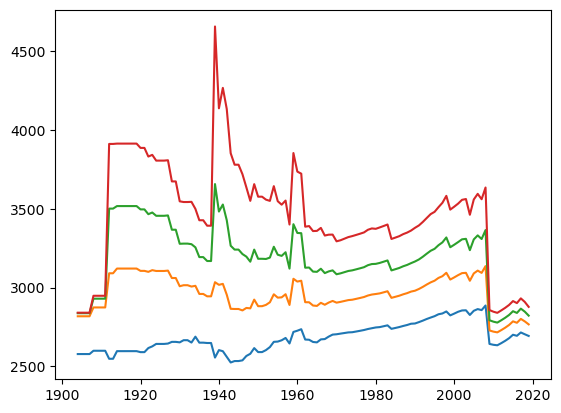

In [133]:

plt.plot( return_levels.year, return_levels.cate1 )
plt.plot( return_levels.year, return_levels.cate2 )
plt.plot( return_levels.year, return_levels.cate3 )
plt.plot( return_levels.year, return_levels.cate4 )



In [31]:
series_df.loc[ series_df['year'] == 1972 ]

,sealevel,year,yearly_avg
Times,,,


In [ ]:

summarybm = modeli.get_summary(
    return_period=[10, 25, 50, 100, 200],
    alpha=0.95)
print( summarybm )
print( summarybm.values[0] )

In [ ]:

#plt.scatter( mean_sea_levels[70:], scale_list[70:] )
#scale_list

In [40]:
#plt.scatter(mean_sea_levels2, c_list)

In [621]:

print( "Location parameter {}, scale parameter {}, shape parameter {}".format(
     modeli.distribution.fixed_parameters['floc'], modeli.distribution.mle_parameters, 0
       ))


Location parameter 2200, scale parameter {'scale': 80.12976101222057}, shape parameter 0


In [622]:
a = modeli.distribution


In [623]:
series


Times
1904-01-01 06:00:00     960.999998
1904-01-01 07:00:00     991.999998
1904-01-01 07:59:59     960.999997
1904-01-01 09:00:00     899.999997
1904-01-01 10:00:00     808.999997
                          ...     
2019-10-31 19:00:00    1201.667554
2019-10-31 19:59:59    1272.667554
2019-10-31 21:00:00    1349.667553
2019-10-31 22:00:00    1454.667553
2019-10-31 22:59:59    1561.667553
Name: sea_level, Length: 981716, dtype: float64

# Time series analysis

In [481]:
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pandas as pd
from pyextremes import EVA
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn import datasets
import math
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from datetime import datetime

from matplotlib import pyplot as plt
from scipy.stats import boxcox

import math

import warnings
warnings.filterwarnings('ignore')


In [482]:

pth1 = r"../data/gaugestation/global_daily_rqds_e993_e0af_572d.csv"
series = pd.read_csv( pth1, index_col = 1,
                     parse_dates = True ).squeeze()
series = series.iloc[1:]
series.head()
series2 = series[ ['sea_level' ] ]
#series2.index.append(pd.date_range(start=series2.Times.iloc[-1], 
#                                                    periods= 35600, freq='d', closed='right'))

#series['Times'] = series.index.str.slice(start=0, stop=10) + " "+ series.index.str.slice(start=11, stop=19)
print(series.columns)
series['Times'] = series.index.str.slice(start=0, stop=10) + " "+ series.index.str.slice(start=11, stop=19)
series['Times'] = pd.to_datetime(series['Times'], format= "%Y-%m-%d %H:%M:%S")

series['Year']  = series.Times.dt.year.tolist()

series.set_index(['Times'], inplace = True)


#series2.index = series2
series = series['sea_level']
series = series.astype(float)



Index(['sea_level', 'latitude', 'longitude', 'station_name', 'station_country',
       'station_country_code', 'record_id', 'uhslc_id', 'version', 'gloss_id',
       'ssc_id', 'decimation_method', 'reference_code', 'reference_offset'],
      dtype='object')


In [483]:
future_series = pd.DataFrame(index= pd.date_range(start=series.index[-1], periods= 35600, freq='d', closed='right') )

series = (
    series
    .sort_index(ascending=True)
    .astype(float)
    .fillna(method='ffill')
    .dropna()
    .loc[pd.to_datetime("1904"):]
)


In [484]:

mstl = MSTL( series, periods=( 30, 365 ), stl_kwargs={"seasonal_deg": 0})
results = mstl.fit()

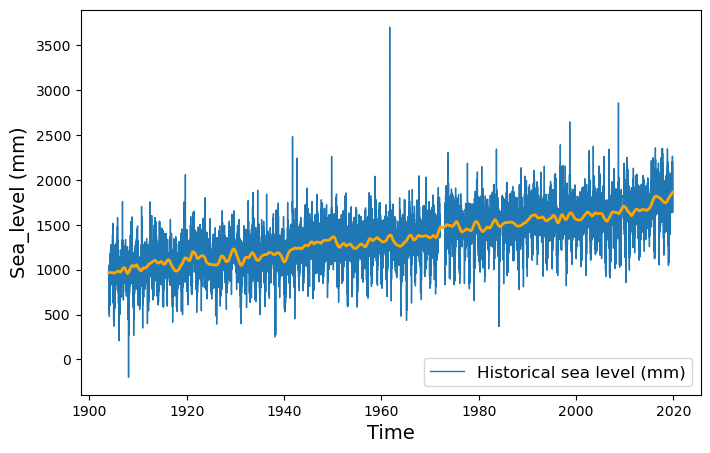

,0
1904-01-02 12:00:00,967.007154
1904-01-03 12:00:00,967.036703
1904-01-04 12:00:00,967.065892
1904-01-05 12:00:00,967.094721
1904-01-06 12:00:00,967.123189
...,...
2117-04-15 12:00:00,NaN
2117-04-16 12:00:00,NaN
2117-04-17 12:00:00,NaN
2117-04-18 12:00:00,NaN


In [452]:

###############################################################################
fig = plt.figure(figsize=(8,5))

plt.plot( series, linewidth= 1 )

plt.plot( results.trend, linewidth= 2, color = "orange")
plt.legend(["Historical sea level (mm)"], loc ="lower right", fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Sea_level (mm)', fontsize=14)
#fig.savefig('/Users/yuhan/Desktop/sealevel_raw.jpg', bbox_inches='tight', dpi=300)

plt.show()

series2 = pd.concat( [results.trend, future_series])
series2

ADF Statistic: -11.139788
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


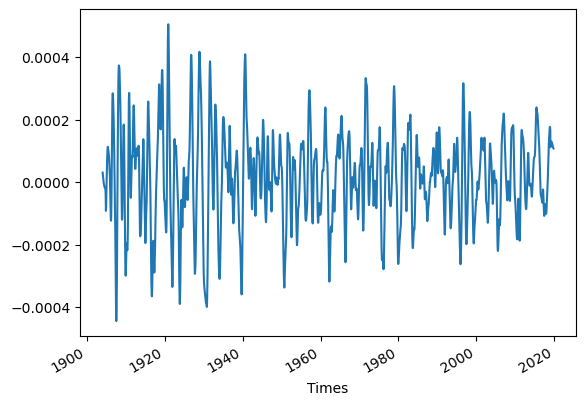

In [433]:
sealevel_log = np.log( results.trend )
#series['moving_avg_log']  = series['sealevel_log'] .rolling( 24).mean()

sealevel_log_diff = sealevel_log - sealevel_log.shift(1)
sealevel_log_diff.dropna().plot()

sealevel_log_diff2 = sealevel_log_diff.dropna()
sealevel_log_diff2.tail()

result = adfuller(sealevel_log_diff2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [439]:

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# split dataset
X    = sealevel_log_diff2.values
time = sealevel_log_diff2.index
trainLength = 10
train, test     = X[1:len(X)- trainLength], X[len(X)- trainLength:]
trainT, testT   = time[1:len(X)- trainLength], time[len(X)- trainLength:]
window = 4
# train autoregression
model = AutoReg(train, lags= window)
model_fit1 = model.fit()

model3 = ARIMA( train, order=(14, 1, 2))  
results_ARIMA = model3.fit()  
print( len(train) , len( model_fit1.fittedvalues))


42295 42291


Text(0.5, 1.0, 'Differencing of log-scale data')

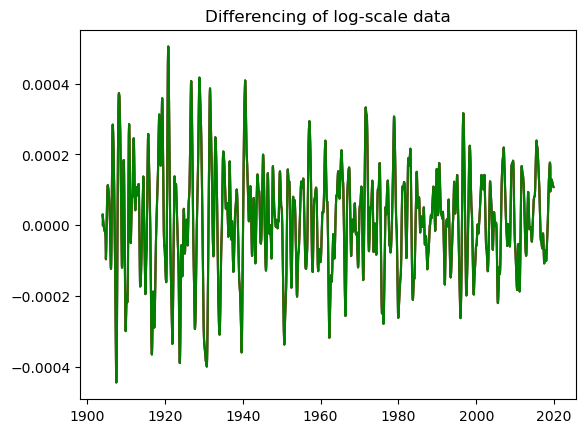

In [440]:

plt.plot( time, X )
plt.plot( trainT[4:], model_fit1.fittedvalues, color='red')

plt.plot( trainT, results_ARIMA.fittedvalues, color='green')
plt.title('Differencing of log-scale data')


In [441]:
#filtered_df = series2.loc[(series2.index >=  series.index[-1] ) ] 
#filtered_df
model_fit1.params
results_ARIMA.params

array([ 2.02897178e-01,  1.84019790e-01,  1.94115108e-01,  1.65230604e-01,
        1.37632506e-01,  1.05590622e-01,  7.56616417e-02,  5.28415612e-02,
        3.08049458e-02,  9.43626499e-03, -1.14222781e-02, -3.19101240e-02,
       -5.21799145e-02, -7.23818874e-02,  3.17084809e-02,  3.04163022e-02,
        1.00000000e-10])

In [446]:
# line plot of residuals
residuals = pd.DataFrame( results_ARIMA.resid)
#residuals.plot()
plt.show()
# density plot of residuals
#residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
#print(residuals.describe())

In [313]:
filtered_df = series2.loc[(series2.index >=  series.index[-1] ) ] 
filtered_df.fillna(0)

indices =  filtered_df.index
values  = filtered_df.values

In [325]:
len( values )
coef = model_fit1.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range( len(values) ):
    length = len(history) 
    lag = [history[i] for i in range(length-window,length)] 
    yhat = coef[0] 
    for d in range(window): 
        yhat += coef[d+1] * lag[window-d-1] 
    #obs = test[t] 
    if math.isinf( yhat ):
        print( lag)
        print("index is", t)
        break
    predictions.append(yhat) 
    history.append(yhat) 
    #print('predicted=%f, expected=%f' % (yhat, obs))
#rmse = sqrt(mean_squared_error(test, predictions))
#print('Test RMSE: %.3f' % rmse)
# plot
#plt.plot( predictions)

In [307]:
predictions_ARIMA_diff = pd.Series( predictions , copy=True)
print( predictions_ARIMA_diff.head(), len(predictions_ARIMA_diff) )
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

0    0.000108
1    0.000108
2    0.000108
3    0.000108
4    0.000108
dtype: float64 35600


0    0.000108
1    0.000216
2    0.000324
3    0.000432
4    0.000540
dtype: float64

In [308]:
print( filtered_df.index )
print( len(predictions_ARIMA_diff_cumsum))

DatetimeIndex(['2019-10-31 12:00:00', '2019-11-01 12:00:00',
               '2019-11-02 12:00:00', '2019-11-03 12:00:00',
               '2019-11-04 12:00:00', '2019-11-05 12:00:00',
               '2019-11-06 12:00:00', '2019-11-07 12:00:00',
               '2019-11-08 12:00:00', '2019-11-09 12:00:00',
               ...
               '2117-04-10 12:00:00', '2117-04-11 12:00:00',
               '2117-04-12 12:00:00', '2117-04-13 12:00:00',
               '2117-04-14 12:00:00', '2117-04-15 12:00:00',
               '2117-04-16 12:00:00', '2117-04-17 12:00:00',
               '2117-04-18 12:00:00', '2117-04-19 12:00:00'],
              dtype='datetime64[ns]', length=35600, freq=None)
35600


In [309]:
predictions_ARIMA_diff_cumsumix = pd.Series(predictions_ARIMA_diff_cumsum.tolist(), 
                                  index= filtered_df.index)

print( predictions_ARIMA_diff_cumsumix.tail() )

predictions_ARIMA_log = pd.Series( sealevel_log.iloc[-1], 
                                  index= filtered_df.index)

print( predictions_ARIMA_log.tail() )

predictions_ARIMA_log = pd.Series(predictions_ARIMA_log.values + predictions_ARIMA_diff_cumsumix.values, 
                                  index= predictions_ARIMA_log.index)

print( predictions_ARIMA_log.tail() )

##########################################

2117-04-15 12:00:00    0.561427
2117-04-16 12:00:00    0.561443
2117-04-17 12:00:00    0.561458
2117-04-18 12:00:00    0.561474
2117-04-19 12:00:00    0.561490
dtype: float64
2117-04-15 12:00:00    7.529639
2117-04-16 12:00:00    7.529639
2117-04-17 12:00:00    7.529639
2117-04-18 12:00:00    7.529639
2117-04-19 12:00:00    7.529639
dtype: float64
2117-04-15 12:00:00    8.091067
2117-04-16 12:00:00    8.091082
2117-04-17 12:00:00    8.091098
2117-04-18 12:00:00    8.091114
2117-04-19 12:00:00    8.091129
dtype: float64


In [310]:

predictions_ARPred = np.exp( predictions_ARIMA_log)
predictions_ARPred =   predictions_ARPred
predictions_ARPred
#plt.plot(predictions_ARPred )

2019-10-31 12:00:00    1862.635306
2019-11-01 12:00:00    1862.836564
2019-11-02 12:00:00    1863.037669
2019-11-03 12:00:00    1863.238602
2019-11-04 12:00:00    1863.439349
                          ...     
2117-04-15 12:00:00    3265.168463
2117-04-16 12:00:00    3265.219554
2117-04-17 12:00:00    3265.270646
2117-04-18 12:00:00    3265.321739
2117-04-19 12:00:00    3265.372832
Length: 35600, dtype: float64

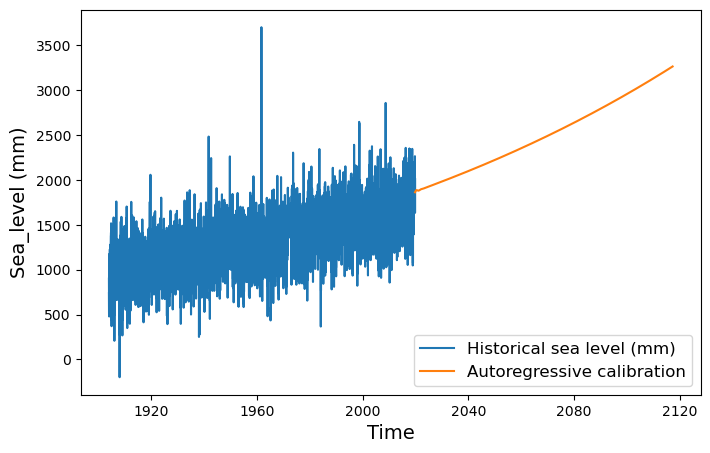

In [400]:
##############################################################################
fig = plt.figure(figsize=(8,5))

plt.plot( series )
#plt.plot(predictions_ARIMA)
plt.plot(predictions_ARPred )
plt.legend(["Historical sea level (mm)",
            "Autoregressive calibration",
            "Autoregressive prediction"], loc ="lower right", fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Sea_level (mm)', fontsize=14)
#fig.savefig('/Users/yuhan/Desktop/sealevel_fit.jpg', bbox_inches='tight', dpi=300)

plt.show()

In [485]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


In [486]:
series2 = pd.concat( [results.trend, future_series])

filtered_df = series2.loc[(series2.index >=  series.index[-1] ) ] 
filtered_df.fillna(0)

indices =  filtered_df.index
values  = filtered_df.values


In [487]:
series2 = pd.concat( [results.trend, future_series])
series2 = series2.fillna(0)
#series2.index
series2.loc[(series2.index >=  series.index[-1] ) ].index

DatetimeIndex(['2019-10-31 12:00:00', '2019-11-01 12:00:00',
               '2019-11-02 12:00:00', '2019-11-03 12:00:00',
               '2019-11-04 12:00:00', '2019-11-05 12:00:00',
               '2019-11-06 12:00:00', '2019-11-07 12:00:00',
               '2019-11-08 12:00:00', '2019-11-09 12:00:00',
               ...
               '2117-04-10 12:00:00', '2117-04-11 12:00:00',
               '2117-04-12 12:00:00', '2117-04-13 12:00:00',
               '2117-04-14 12:00:00', '2117-04-15 12:00:00',
               '2117-04-16 12:00:00', '2117-04-17 12:00:00',
               '2117-04-18 12:00:00', '2117-04-19 12:00:00'],
              dtype='datetime64[ns]', length=35600, freq=None)

In [490]:

# split into train and test sets
X = series2.values
size = len( series2.loc[(series2.index <=  series.index[-1] ) ] .values )
print( len(X), size )
train, test = X[0:size-14], X[size-14:len(X)]
history2 = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
  print(t)
  model     = ARIMA(history2, order=(14, 1, 2))
  model_fit = model.fit()
  output    = model_fit.forecast()
  yhat      = output[0]
  predictions.append(yhat)
  obs       = yhat
  history2.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


77906 42307
0
predicted=1859.821651, expected=1859.821651
1


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (42294,) + inhomogeneous part.

In [489]:
history2

[14.828570022574379,
 25.05251750458958,
 41.36337376508291,
 25.579423192647994,
 -44.48297548545571,
 -28.882029549373044,
 11.818182830346462,
 31.734665629176774,
 15.830554217053068,
 -31.742521798950964,
 19.943707012897825,
 51.63125144235736,
 45.38872766232636,
 -13.164044183058243,
 -57.35654906881635,
 -56.59459475799326,
 -44.250978491643565,
 -33.3834863116928,
 -7.9695579890069315,
 -66.97337426813326,
 -63.29367742274793,
 -3.7185671935032225,
 11.073666688306167,
 57.793582782929334,
 30.03576391441685,
 8.378487832825986,
 17.03149963234532,
 3.6129077994342564,
 17.085830551718207,
 28.44124040611952,
 17.745742210733603,
 20.742272156454163,
 41.88634412103828,
 22.151846248910495,
 -36.313335321813554,
 -29.918063121924924,
 7.109333286219847,
 33.82051905383556,
 10.541490406518994,
 -22.759545079299254,
 10.05293808285492,
 50.49018702717623,
 42.10435830057044,
 -9.384458532111399,
 -54.14831399566264,
 -54.68715001778901,
 -47.072846002438695,
 -30.2542445227699